In [1]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
import pandas as pd
from rdkit import DataStructs
from sklearn.cluster import KMeans
import numpy as np
import csv

## read smis form BiDe.csv

In [2]:
csv_root = "./BiDe.csv"
df = pd.read_csv(csv_root)
smis = df["smi"].tolist()
print(len(smis))

89870


## substrate selection

In [3]:
def has_metal_B_P_Si(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        raise ValueError('Invalid molecule')
    metal_pattern = Chem.MolFromSmarts('[Ti,Mn,Fe,Co,Ni,Cu,Zn,Ga,Ge,As,Se,Rb,Sr,Zr,Nb,Mo,Ru,Pd,Ag,Cd,In,Sn,Sb,Te,Ba,Hf,Ta,W,Pt,Au,Hg,Pb,Bi]')
    boron_pattern = Chem.MolFromSmarts('[B]')
    phosphorous_pattern = Chem.MolFromSmarts('[P]')
    silicium_pattern = Chem.MolFromSmarts('[Si]')
    if mol.HasSubstructMatch(metal_pattern):
        return True
    if mol.HasSubstructMatch(boron_pattern):
        return True
    if mol.HasSubstructMatch(phosphorous_pattern):
        return True
    if mol.HasSubstructMatch(silicium_pattern):
        return True
    else:
        return False
    
def NC_sele(smi):
    NC_pattern = Chem.MolFromSmarts('[C-]#[N+]')
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        print(smi)
        # raise ValueError("Invalid SMILES string")
    else:
        return mol.HasSubstructMatch(NC_pattern)
    
def count_aldehyde_and_ketone_group(smi):
    aldehyde_pattern = Chem.MolFromSmarts("[CX3H1](=O)[#6]")
    ketone_pattern = Chem.MolFromSmarts("[#6][CX3](=O)[#6]")
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        pass
    else:
        return len(mol.GetSubstructMatches(aldehyde_pattern)) + len(mol.GetSubstructMatches(ketone_pattern))

def count_carboxlic_acid_group(smi):
    mol = Chem.MolFromSmiles(smi)
    carboxlic_acid_pattern = Chem.MolFromSmarts("[#6]C(=O)(-[OH])")
    if mol is None:
        pass
    else:
        return len(mol.GetSubstructMatches(carboxlic_acid_pattern))

def count_primary_amine(smi):
    mol = Chem.MolFromSmiles(smi)
    primary_aliphatic_amine_pattern = Chem.MolFromSmarts('[N;X3;H2][#6;!$(C=[C,O,N,S]);!$(C#*)]')
    if mol is None:
        pass
    else:
        '''
        if not (count_aldehyde_and_ketone_group(smi)) and (not count_carboxlic_acid_group(smi)):
            return mol.HasSubstructMatch(primary_aliphatic_amine_pattern)
        else:
            pass
        '''
        return len(mol.GetSubstructMatches(primary_aliphatic_amine_pattern))
    
def aldehyde_and_carboxylic_acid_sele(smi):
    mol = Chem.MolFromSmiles(smi)
    aldehyde_and_carboxylic_acid_pattern_0 = Chem.MolFromSmarts("[#6,#1]C(=O)[#6;!R]*[#6;!R]C(=O)(-[OH])")
    aldehyde_and_carboxylic_acid_pattern_1 = Chem.MolFromSmarts("[#6,#1]C(=O)[#6;!R][#6;!R]C(=O)(-[OH])")
    aldehyde_and_carboxylic_acid_pattern_2 = Chem.MolFromSmarts("[#6,#1]C(=O)ccC(=O)(-[OH])")
    if mol is None:
        pass
    else:
        return mol.HasSubstructMatch(aldehyde_and_carboxylic_acid_pattern_0) \
            or mol.HasSubstructMatch(aldehyde_and_carboxylic_acid_pattern_1) \
            or mol.HasSubstructMatch(aldehyde_and_carboxylic_acid_pattern_2)
# NC_sele("CCCN#C")  --> invalid smi
# NC_sele("[C-]#[N+]CCC")

def multiple_bond_amine_sele(smi):
    mol = Chem.MolFromSmiles(smi)
    multiple_bond_amine_pattern = Chem.MolFromSmarts("[NX3][CX3]=[CX3]")
    if mol is None:
        pass
    elif not count_primary_amine(smi):
        pass
    else:
        if mol.HasSubstructMatch(multiple_bond_amine_pattern):
            return True
        
def clean_amine(amine):
    if multiple_bond_amine_sele(amine) or count_aldehyde_and_ketone_group(amine) or count_carboxlic_acid_group(amine):
        return False
    else:
        return True
    
def clean_aldehyde_and_carboxylic_acid(aldehyde_and_carboxylic_acid):
    if count_primary_amine(aldehyde_and_carboxylic_acid) or (count_aldehyde_and_ketone_group(aldehyde_and_carboxylic_acid) + count_carboxlic_acid_group(aldehyde_and_carboxylic_acid)) > 2:
        return False
    else:
        return True

[09:33:37] Explicit valence for atom # 26 Cl, 2, is greater than permitted
[09:33:37] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[09:33:37] Explicit valence for atom # 0 Cl, 2, is greater than permitted


C[C]1[C](C)[C](C)[C](C)[C](C)[C]1C.C[C]1[C](C)[C](C)[C](C)[C](C)[C]1C.Cl[Ru]1[ClH][Ru](Cl)[ClH]1
[Cl-][Ni+2]1([Cl-])[P](c2ccccc2)(c2ccccc2)c2ccccc2Oc2ccccc2[P]1(c1ccccc1)c1ccccc1
[Cl-][Cu+]([P](c1ccccc1)(c1ccccc1)c1ccccc1)([P](c1ccccc1)(c1ccccc1)c1ccccc1)[P](c1ccccc1)(c1ccccc1)c1ccccc1


[09:33:38] Explicit valence for atom # 1 Br, 3, is greater than permitted


Br[Br-]Br.C[N+](C)(C)c1ccccc1


[09:33:39] Explicit valence for atom # 1 Br, 3, is greater than permitted
[09:33:39] Explicit valence for atom # 1 Br, 3, is greater than permitted


Br[BrH]Br.O=C1CCCN1
Br[Br-]Br.CCCC[N+](CCCC)(CCCC)CCCC


[09:33:40] WARNING: not removing hydrogen atom without neighbors
[09:33:40] Explicit valence for atom # 1 Br, 3, is greater than permitted


Br[Br-]Br.C[N+](C)(C)Cc1ccccc1
Cc1cc(C)cc(C)c1.Cc1cc(C)cc(C)c1.[Cl-]1[Ru+][Cl-][Ru+]1


[09:33:40] Explicit valence for atom # 18 Cl, 3, is greater than permitted


25


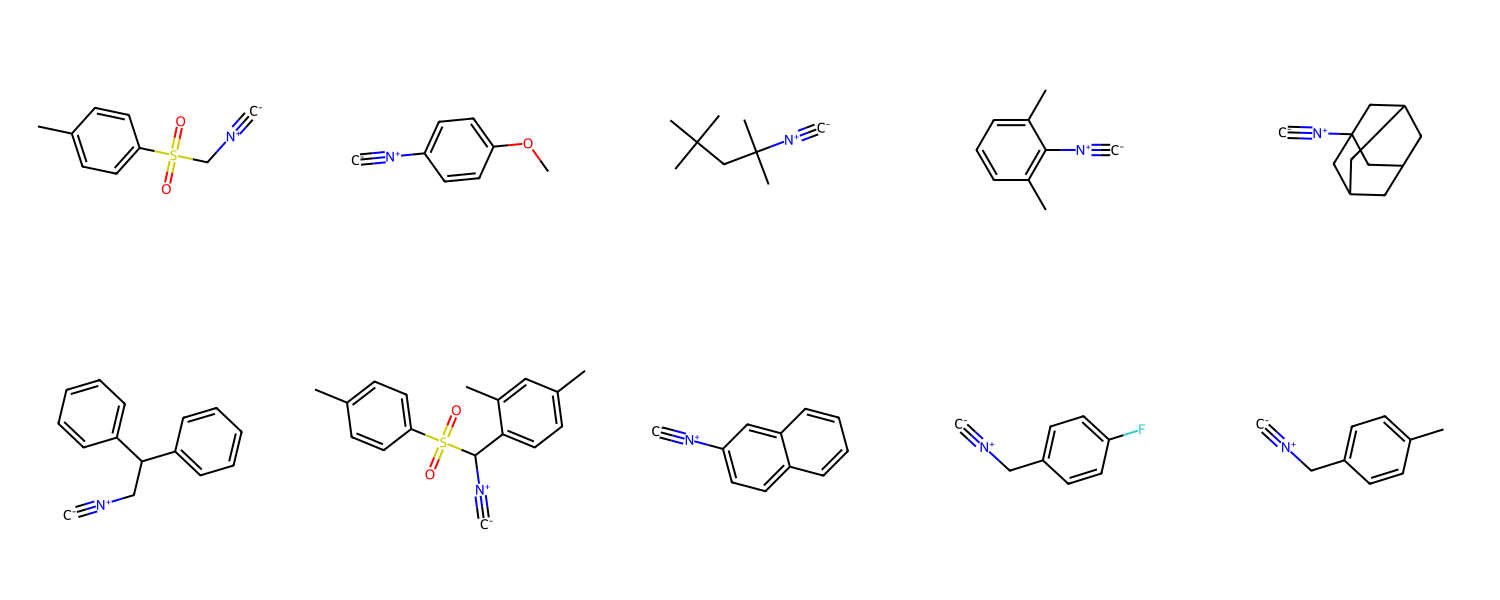

In [14]:
NC_dict = {}
num = -1
for smi in smis:
    num += 1
    if NC_sele(smi) and not has_metal_B_P_Si(smi):
        NC_dict[num] = smi
    else:
        continue
print(len(NC_dict))
Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in list(NC_dict.values())[0:10]], molsPerRow=5, subImgSize=(300, 300))   




[09:30:28] Explicit valence for atom # 26 Cl, 2, is greater than permitted
[09:30:29] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[09:30:29] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[09:30:30] Explicit valence for atom # 1 Br, 3, is greater than permitted
[09:30:32] Explicit valence for atom # 1 Br, 3, is greater than permitted
[09:30:32] Explicit valence for atom # 1 Br, 3, is greater than permitted
[09:30:33] WARNING: not removing hydrogen atom without neighbors
[09:30:33] Explicit valence for atom # 1 Br, 3, is greater than permitted
[09:30:34] Explicit valence for atom # 18 Cl, 3, is greater than permitted


11182


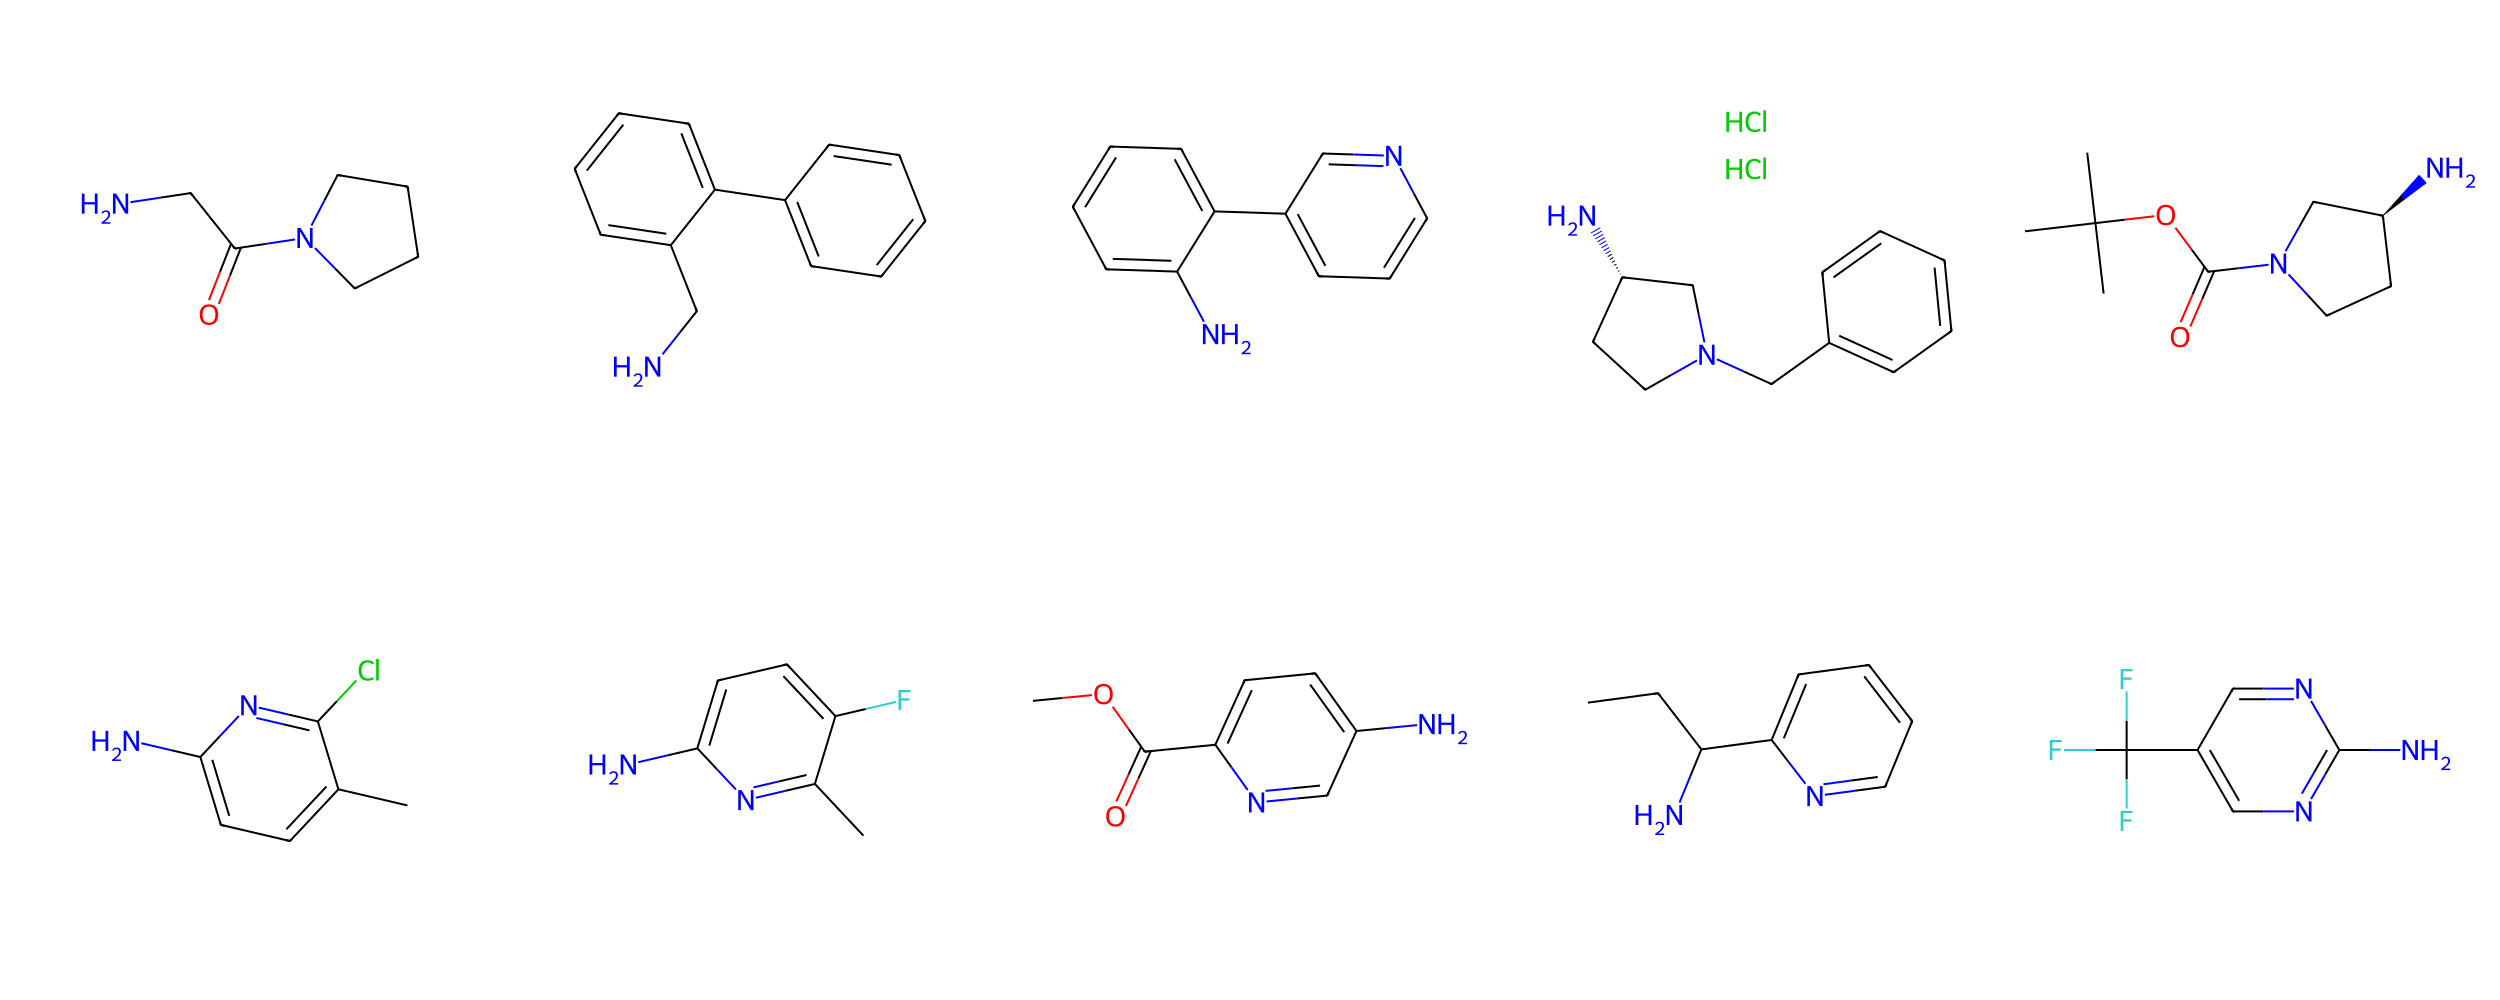

In [10]:
primary_aliphatic_amine_dict = {}
num = -1
for smi in smis:
    num += 1
    if count_primary_amine(smi) == 1 and not has_metal_B_P_Si(smi) and clean_amine(smi):
        primary_aliphatic_amine_dict[num] = smi
    else:
        continue

print(len(primary_aliphatic_amine_dict))
Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in list(primary_aliphatic_amine_dict.values())[0:10]], molsPerRow=5, subImgSize=(500, 500))

[09:31:36] Explicit valence for atom # 26 Cl, 2, is greater than permitted
[09:31:37] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[09:31:37] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[09:31:38] Explicit valence for atom # 1 Br, 3, is greater than permitted
[09:31:40] Explicit valence for atom # 1 Br, 3, is greater than permitted
[09:31:40] Explicit valence for atom # 1 Br, 3, is greater than permitted
[09:31:40] WARNING: not removing hydrogen atom without neighbors
[09:31:41] Explicit valence for atom # 1 Br, 3, is greater than permitted
[09:31:41] Explicit valence for atom # 18 Cl, 3, is greater than permitted


67


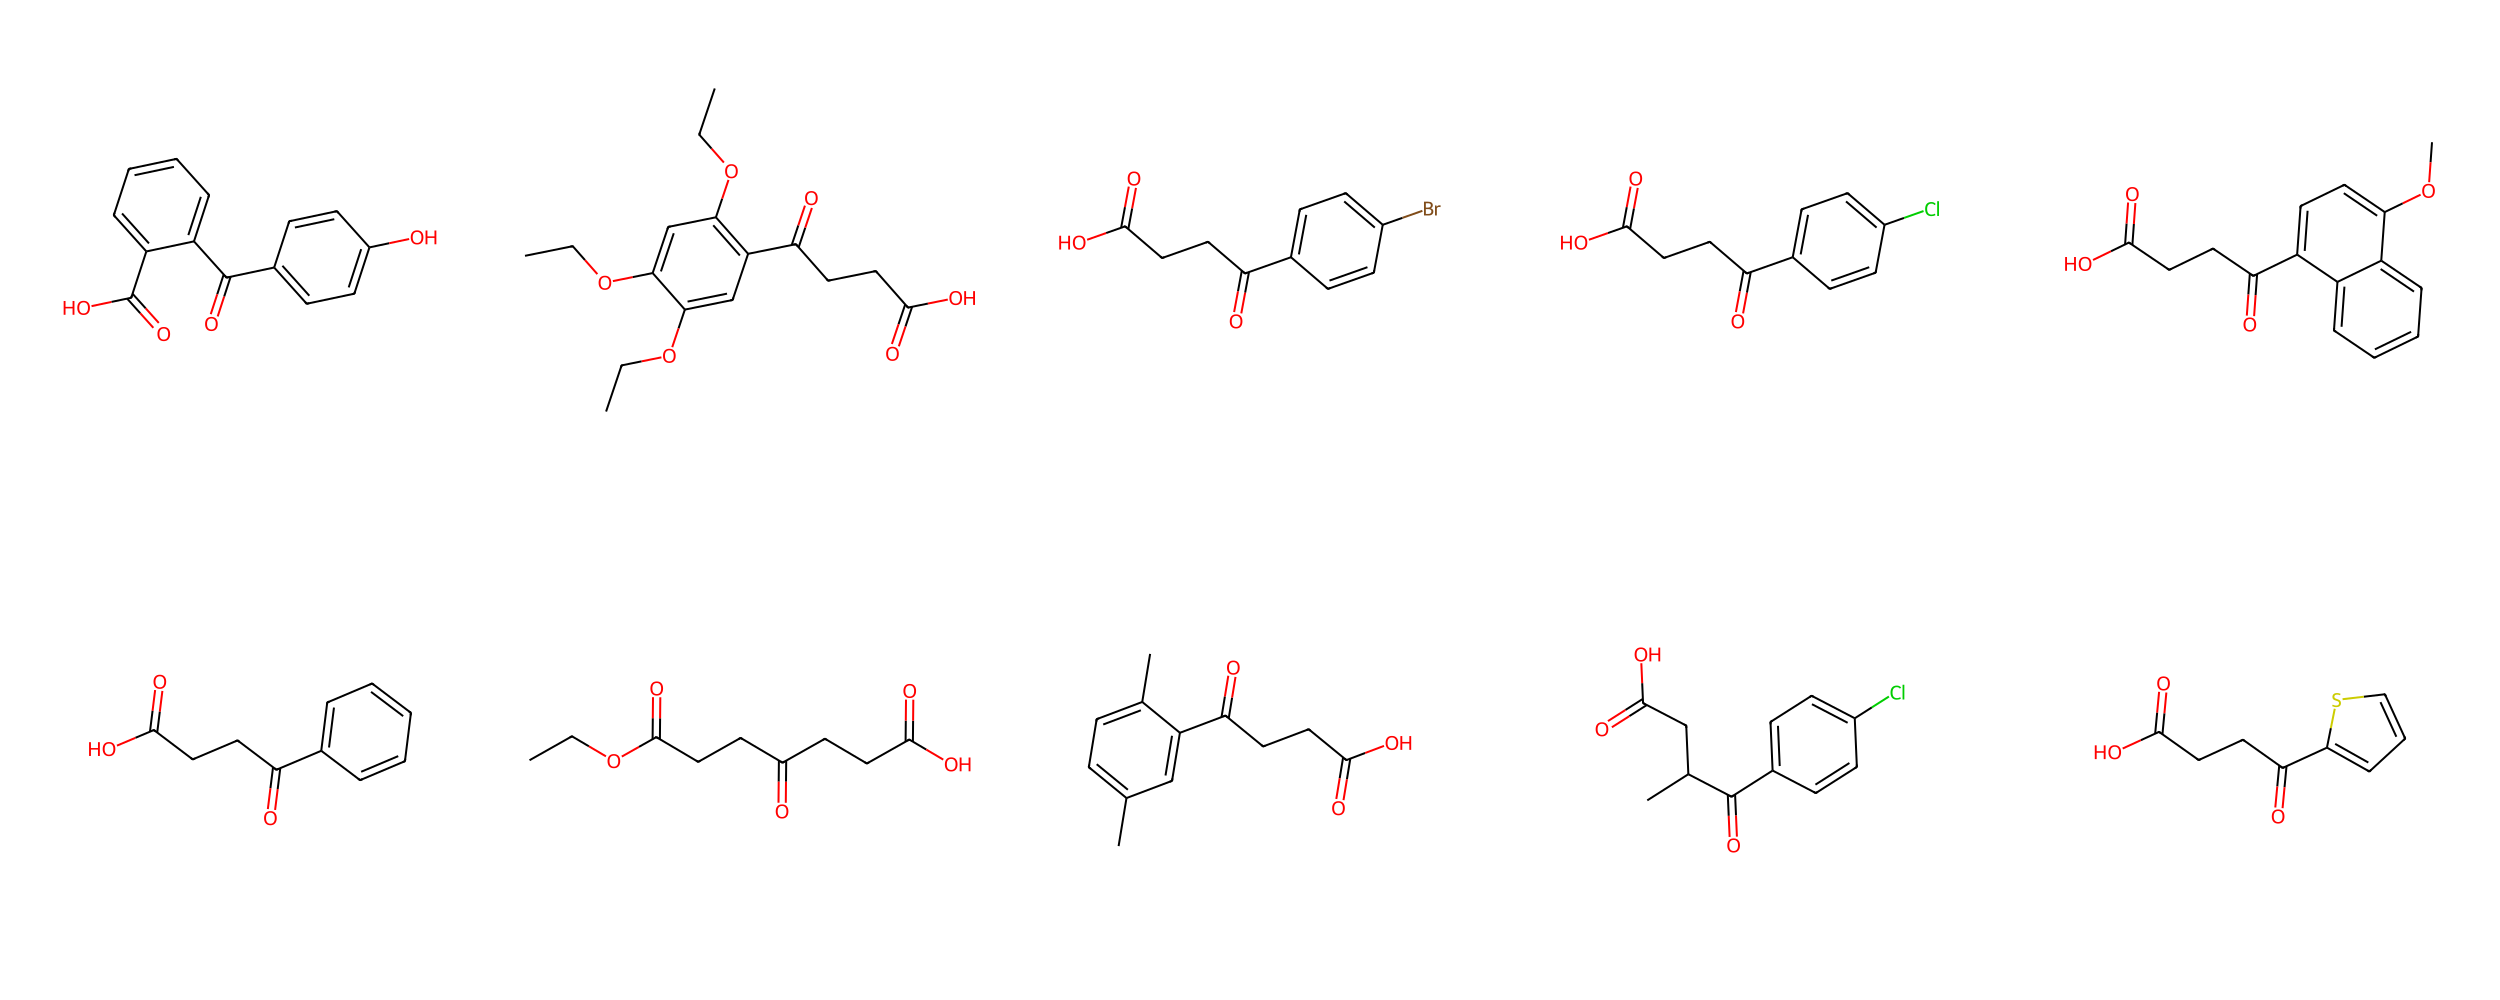

In [12]:
aldehyde_and_carboxylic_acid_dict = {}
num = -1
for smi in smis:
    num += 1
    if aldehyde_and_carboxylic_acid_sele(smi) and (not has_metal_B_P_Si(smi)) and clean_aldehyde_and_carboxylic_acid(smi):
        aldehyde_and_carboxylic_acid_dict[num] = smi
    else:
        continue

print(len(aldehyde_and_carboxylic_acid_dict))
Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in list(aldehyde_and_carboxylic_acid_dict.values())[0:10]], molsPerRow=5, subImgSize=(500, 500))


## save as csv

In [ ]:
#for key in NC_dict.keys():
    #print(key)
    #df_NC_key = df.iloc[key-1,:]
df_NC = df.iloc[list(NC_dict.keys())].reset_index(drop=True).drop(["product_id","availability","price"], axis = 1)
df_NC["NC_id"] = [f"NC{i+1}" for i in range(len(df_NC))]
cols = df_NC.columns.tolist()
cols = ["NC_id"] + cols[:-1]
df_NC = df_NC[cols]   # cols是存储全部列名的列表
df_NC.to_csv("./NC.csv", index=False)

sele_NC_dict = {}
i = 1
for smi in NC_dict.values():
    sele_NC_dict[f"NC{i}"] = smi
    i += 1
print(sele_NC_dict)

In [ ]:
df_keto_acid = df.iloc[list(aldehyde_and_carboxylic_acid_dict.keys())].reset_index(drop=True).drop(["product_id","availability","price"], axis = 1)
df_keto_acid["keto_acid_id"] = [f"keto_acid{i+1}" for i in range(len(aldehyde_and_carboxylic_acid_dict))]
cols = df_keto_acid.columns.tolist()
cols = ["keto_acid_id"] + cols[:-1]
df_keto_acid = df_keto_acid[cols]   # cols是存储全部列名的列表
df_keto_acid.to_csv("./keto_acid.csv", index=False)

sele_kto_acid_dict = {}
i = 1
for smi in aldehyde_and_carboxylic_acid_dict.values():
    sele_kto_acid_dict[f"keto_acid{i}"] = smi
    i += 1
print(sele_kto_acid_dict)

In [ ]:
df_amine = df.iloc[list(primary_aliphatic_amine_dict.keys())].reset_index(drop=True).drop(["product_id","availability","price"], axis = 1)
df_amine["amine_id"] = [f"amine{i+1}" for i in range(len(df_amine))]
cols = df_amine.columns.tolist()
cols = ["amine_id"] + cols[:-1]
df_amine = df_amine[cols]   # cols是存储全部列名的列表
df_amine.to_csv("./amine.csv", index=False)

sele_amine_dict = {}
i = 1
for smi in primary_aliphatic_amine_dict.values():
    sele_amine_dict[f"amine{i}"] = smi
    i += 1
print(sele_amine_dict)

## Clustering

In [ ]:
def clustering(sele_smi_dict, n_clusters):
    fps = []
    images = []
    id_list = []
    for smiles in sele_smi_dict.values():
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps.append(arr)

    # 对指纹进行聚类
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(fps)

    for i in range(n_clusters):
        # 找到属于该类别的分子
        # cluster_mols = [Chem.MolFromSmiles(list(smi_dict.values())[j]) for j in range(len(fps)) if kmeans.labels_[j] == i]
        id_list.append([list(sele_smi_dict.keys())[j] for j in range(len(fps)) if kmeans.labels_[j] == i])
        # 为每个类别的分子生成一个分子图像的列表
        # img = Draw.MolsToGridImage(cluster_mols, molsPerRow=5, subImgSize=(300,300))  # 调整molsPerRow和subImgSize来改变每行的分子数量和每个分子图像的大小
        # images.append(img)
    return id_list
'''
输出图像
iamge_NC = clustering(NC_dict, 3)
for image in iamge_NC:
    display(image)

iamge_keto_acid = clustering(aldehyde_and_carboxylic_acid_dict, 4)
for image in iamge_keto_acid:
    display(image)

iamge_amine = clustering(primary_aliphatic_amine_dict, 8)
for image in iamge_amine:
    #print(len(image))
    display(image)
'''
NC_list = clustering(sele_NC_dict, 3)
for NC in NC_list:
    print(NC)

keto_acid_list = clustering(sele_kto_acid_dict,4)
for keto_acid in keto_acid_list:
    print(keto_acid)

amine_list = clustering(sele_amine_dict, 8)
for amine in amine_list:
    print(amine)

In [ ]:
# 读取CSV文件
with open('./amine.csv', 'r') as file:
    reader = csv.DictReader(file)
    data = list(reader)


# 创建一个字典，将NC_id与对应的价格映射起来
price_dict = {row['amine_id']: float(row['price_per_gram']) for row in data}
# 列表中价格最低的分子

for idx in range(len(amine_list)):
    min_price_molecule = None
    min_price = float('inf')  # 初始化为正无穷大
    for nc_id in amine_list[idx]:
        if nc_id in price_dict:
            price = price_dict[nc_id]
            if price < min_price:
                min_price = price
                min_price_molecule = nc_id

    # 输出价格最低的分子
    print(f"In cluster {idx}, The molecule with the lowest price is: {min_price_molecule}")


## test

In [ ]:
test_pattern = Chem.MolFromSmarts('[N;X3;H2][C]=[O]')
test_smiles = "CC(=O)N"
test_mol = Chem.MolFromSmiles(test_smiles)
img = Draw.MolToImage(test_mol)
img.save('test_mol.png')
print(test_mol.HasSubstructMatch(test_pattern))


In [ ]:
smi = "[Cl-][Ni+2]1([Cl-])[P](c2ccccc2)(c2ccccc2)c2ccccc2Oc2ccccc2[P]1(c1ccccc1)c1ccccc1"
smi_mol = Chem.MolFromSmiles(smi)
print(smi_mol == None)
# img = Draw.MolToImage(smi_mol)
# img.save('smi_mol.png')

In [ ]:
def judge_primary_aliphatic_amine_groups(entry_smiles):
    mol = Chem.MolFromSmiles(entry_smiles)
    if mol is None:
        raise ValueError('Invalid molecule')
    else:
        primary_aliphatic_amine_pattern = Chem.MolFromSmarts('[N;X3;H2][C;!$(C=[O,N,S])]')
        return mol.HasSubstructMatch((primary_aliphatic_amine_pattern))

judge_primary_aliphatic_amine_groups('CCC(=O)N')

In [ ]:
entry_smiles = "OC(C1=CC=CC(C([H])=O)=C1)=O"
entry_mol = Chem.MolFromSmiles(entry_smiles)
test_pattern = Chem.MolFromSmarts("[CH1](=O)(***C(=O)(-[OH]))")
print(entry_mol.HasSubstructMatch(test_pattern))

entry_mol

In [ ]:
# print((NC_dict))
# print(len(primary_aliphatic_amine_dict))
# print(len(aldehyde_and_carboxylic_acid_dict))

In [ ]:
aldehyde_and_carboxylic_acid_pattern_0 = Chem.MolFromSmarts("[#6,#1]C(=O)[#6]*[#6]C(=O)(-[OH])")
test_smi = "CC(=O)N"
mol = Chem.MolFromSmiles(test_smi)
print(mol.HasSubstructMatch(test_smi))

In [ ]:
enamine_pattern = Chem.MolFromSmarts("C=CN")
enamine_pattern_1 = Chem.MolFromSmarts("C#CN")
test_smi = "C=CNC"
mol = Chem.MolFromSmiles(test_smi)
print(mol.HasSubstructMatch(enamine_pattern) or mol.HasSubstructMatch(enamine_pattern_1))

In [ ]:
def is_enamine(smi):
    primary_aliphatic_amine_pattern = Chem.MolFromSmarts('[N;X3;H2][C;!$(C=[O,N,S])]')
    mol = Chem.MolFromSmiles(test_smi)
    return mol.HasSubstructMatch(primary_aliphatic_amine_pattern)

print(is_enamine("CCC(N)C"))

In [ ]:
def has_aldehyde_group(smi):
    aldehyde_pattern = Chem.MolFromSmarts("[#6,#1]C(=O)[#6]")
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        pass
    else:
        return mol.GetSubstructMatches(aldehyde_pattern)
    
print(len(has_aldehyde_group("[H]C(CC(CC([H])=O)=O)=O")))

In [ ]:
smi = "CC(C1=CC=CC=C1C(O)=O)=O"
print(count_aldehyde_and_ketone_group(smi))
print(count_carboxlic_acid_group(smi))
print(aldehyde_and_carboxylic_acid_sele(smi))
mol0 = Chem.MolFromSmiles(smi)
print(mol0.HasSubstructMatch(Chem.MolFromSmarts("[#6,#1]C(=O)ccC(=O)(-[OH])")))
mol0